**RNN**

In [1]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
from sklearn.metrics import mean_squared_error


data = pd.read_csv('GOOGL_2006-01-01_to_2018-01-01.csv', parse_dates=['Date'])

data = data.drop("Name", axis=1)
data.set_index('Date', inplace=True)


# Ensure data has business day frequency
data = data.asfreq('b')

# Fill missing values
data = data.fillna(method='bfill').fillna(method='ffill')
data_vals = data.values


2024-12-12 08:41:09.399384: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1733992869.542804    1700 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1733992869.584685    1700 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-12 08:41:09.889738: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/tmp/ipykernel_1700/945415132.py:19: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future v

In [ ]:
# Normalize the data (apply MinMaxScaler across all features)
scaler = MinMaxScaler(feature_range=(0, 1))
data_normalized = scaler.fit_transform(data_vals)

# Define sequence length
sequence_length = 100

# Prepare input (X) and output (Y) sequences
X, Y = [], []
for i in range(len(data_normalized) - sequence_length):
    X.append(data_normalized[i:i + sequence_length])  # Input: sequence_length x num_features
    Y.append(data_normalized[i + sequence_length])    # Output: num_features

X = np.array(X)  # Shape: (samples, sequence_length, num_features)
Y = np.array(Y)  # Shape: (samples, num_features)

# Split the data into training and testing sets
split_ratio = 0.8
split_index = int(split_ratio * len(X))
X_train, X_test = X[:split_index], X[split_index:]
Y_train, Y_test = Y[:split_index], Y[split_index:]

IndexError: index 3129 is out of bounds for axis 0 with size 3129

TypeError: 'tuple' object is not callable

2024-12-07 12:58:21.274324: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)
/home/irene/.local/lib/python3.9/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.0532 - learning_rate: 0.0100
Epoch 2/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0013 - learning_rate: 0.0100
Epoch 3/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 6.0327e-04 - learning_rate: 0.0100
Epoch 4/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 4.8812e-04 - learning_rate: 0.0100
Epoch 5/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 4.6253e-04 - learning_rate: 0.0100
Epoch 6/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 4.3633e-04 - learning_rate: 0.0100
Epoch 7/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 4.2649e-04 - learning_rate: 0.0100
Epoch 8/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 5.0637e-04 - learning_rate: 0.0100
Epoch 9/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 6.2468e-04 - learning_rate: 0.0100
Epoch 10/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 3.7097e-04 - learning_rate: 0.0100
Epoch 11/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 3.4824e

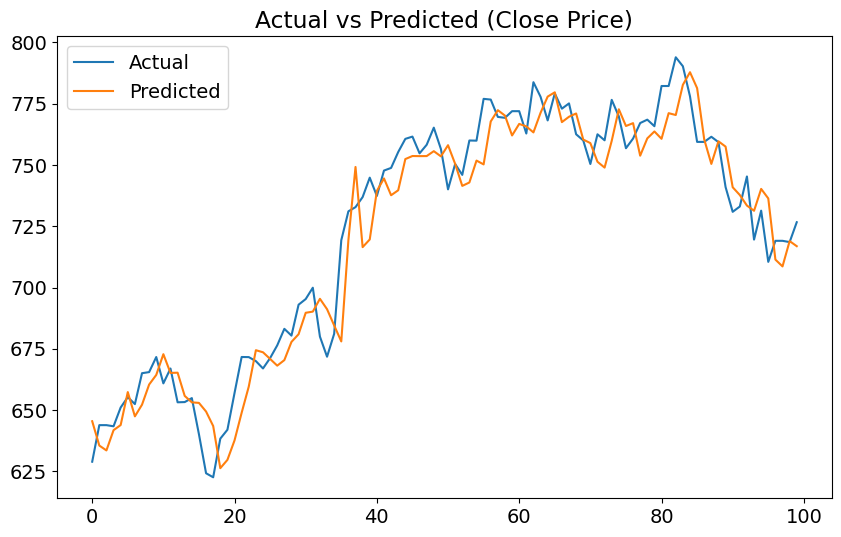

In [4]:
from tensorflow.keras.callbacks import LearningRateScheduler

# Define the scheduler function
def step_decay(epoch):
    initial_lr = 0.01
    drop = 0.5
    epochs_drop = 10
    lr = initial_lr * (drop ** (epoch // epochs_drop))
    return lr

# Create the callback
lr_scheduler = LearningRateScheduler(step_decay)

# Build the RNN model for multivariate input/output
model = Sequential([
    SimpleRNN(units=80, input_shape=(sequence_length, X.shape[2])),  # Sequence length and features
    Dense(units=Y.shape[1])  # Number of output features
])

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(X_train, Y_train, epochs=50, batch_size=64, verbose=1, callbacks=[lr_scheduler])


# Predict on the test set
predictions = model.predict(X_test)

# Inverse scale predictions and actual values for evaluation
predictions_rescaled = scaler.inverse_transform(predictions)
Y_test_rescaled = scaler.inverse_transform(Y_test)

# Evaluate the model using Root Mean Squared Error (RMSE) for the fourth variable 'Close'
rmse = np.sqrt(mean_squared_error(Y_test_rescaled[:,3], predictions_rescaled[:,3]))
print(f"Root Mean Squared Error: {rmse}")

# Optional: Visualize some predictions vs actuals
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 14})

plt.figure(figsize=(10, 6))
plt.plot(Y_test_rescaled[:100, 3], label='Actual')
plt.plot(predictions_rescaled[:100, 3], label='Predicted')
plt.legend()
plt.title("Actual vs Predicted (Close Price)")
plt.savefig("Actual vs Predicted (Close Price).png")
plt.show()

**Forecasting**

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


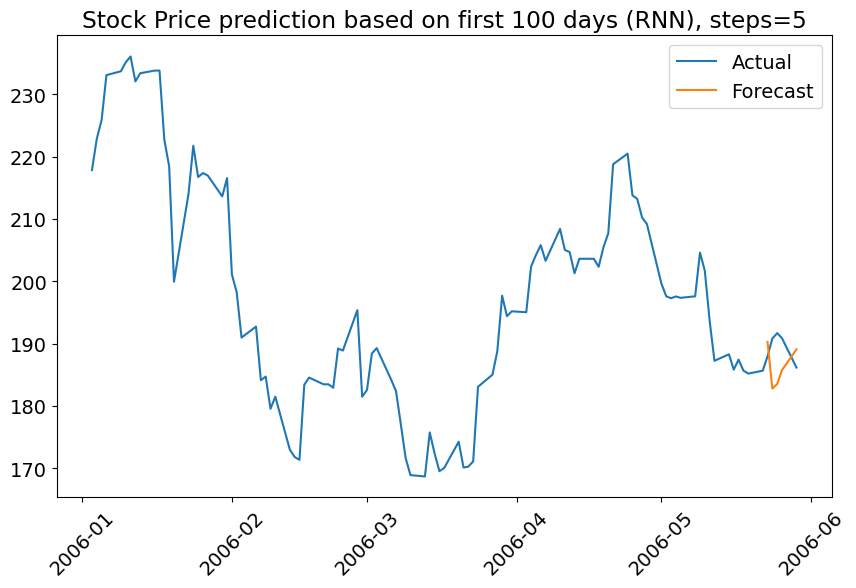

Root Mean Squared Error: 5.846692300532396
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


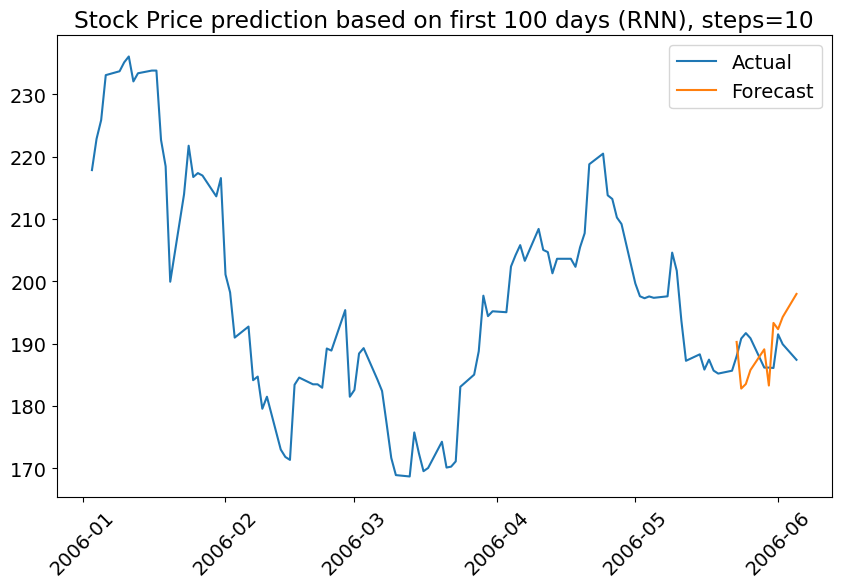

Root Mean Squared Error: 6.021609598294929
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


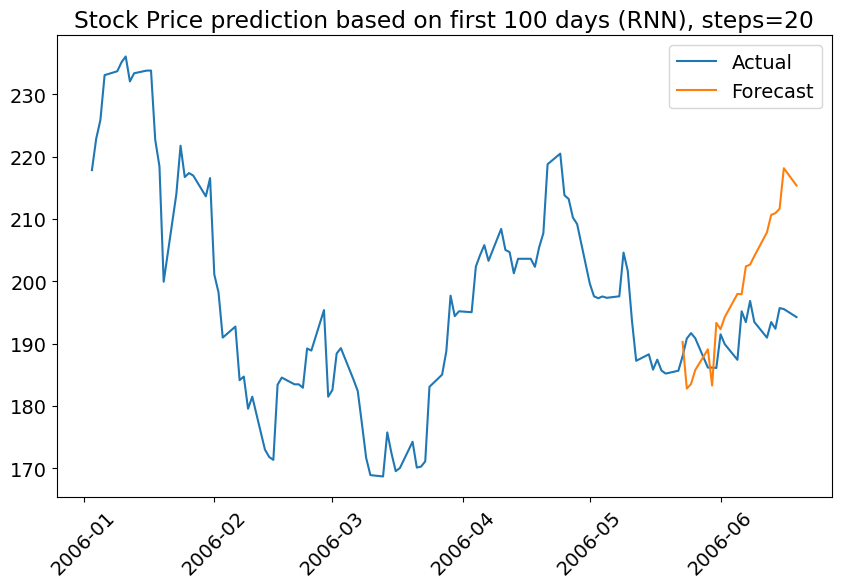

Root Mean Squared Error: 11.680348134798113
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━

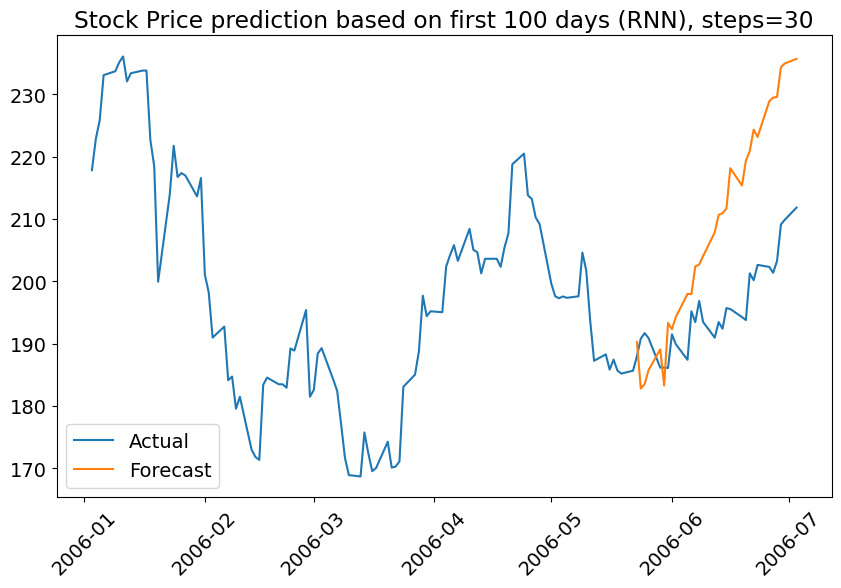

Root Mean Squared Error: 17.11742630181711
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━

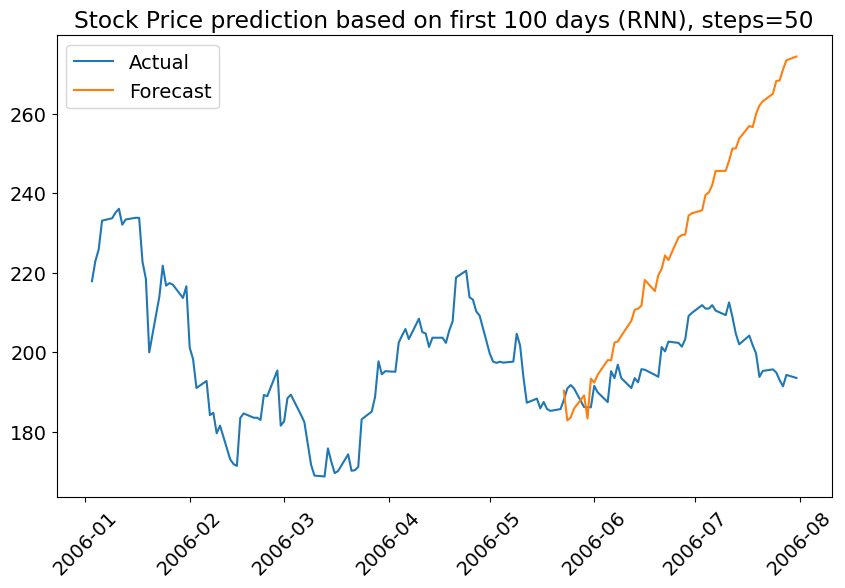

Root Mean Squared Error: 38.87558265261757
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━

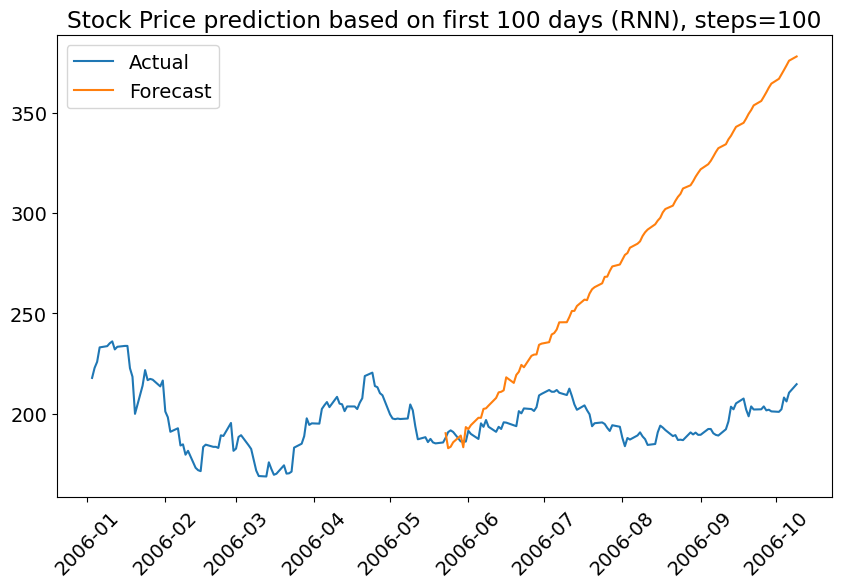

Root Mean Squared Error: 97.99343151613424


In [9]:
rmse_vector={}
# Number of steps to forecast
steps = [5, 10, 20, 30, 50, 100]
for s in range(0,len(steps)):
    prediction_X = X[0]  # Ensure this is a sequence of shape (sequence_length, num_features)
    # Store forecasts
    forecasts = []

    for i in range(steps[s]):
        # Reshape prediction_X to include batch dimension
        prediction_X_batch = prediction_X.reshape((1, prediction_X.shape[0], prediction_X.shape[1]))

        # Predict the next step
        forecast_new = model.predict(prediction_X_batch)

        # Add the prediction to forecasts
        forecasts.append(forecast_new[0])  # Remove batch dimension from prediction

        # Update prediction_X: Remove the first value and append the new prediction
        prediction_X = np.vstack([prediction_X[1:], forecast_new])

    # Convert forecasts to a NumPy array for further processing
    forecasts = np.array(forecasts)

    # Inverse transform the forecasts if needed (to return to original scale)
    forecasts_rescaled = scaler.inverse_transform(forecasts)

    plt.figure(figsize=(10, 6))

    # Plot actual values
    plt.plot(data.index[:100+steps[s]],data_vals[:100+steps[s], 3], label='Actual')

    # Plot predicted values
    plt.plot(data.index[100:100+steps[s]],forecasts_rescaled[:, 3], label='Forecast')

    # Rotate the x-axis labels for better readability
    plt.xticks(rotation=45)

    # Add legend and title
    plt.legend()
    plt.title("Stock Price prediction based on first 100 days (RNN), steps="+str(steps[s]))
    plt.savefig("Stock_RNN_prediction"+str(steps[s])+".png")
    plt.show()

    rmse = np.sqrt(mean_squared_error(data_vals[100:100+steps[s], 3], forecasts_rescaled[:, 3]))
    rmse_vector[s]=rmse
    print(f"Root Mean Squared Error: {rmse}")

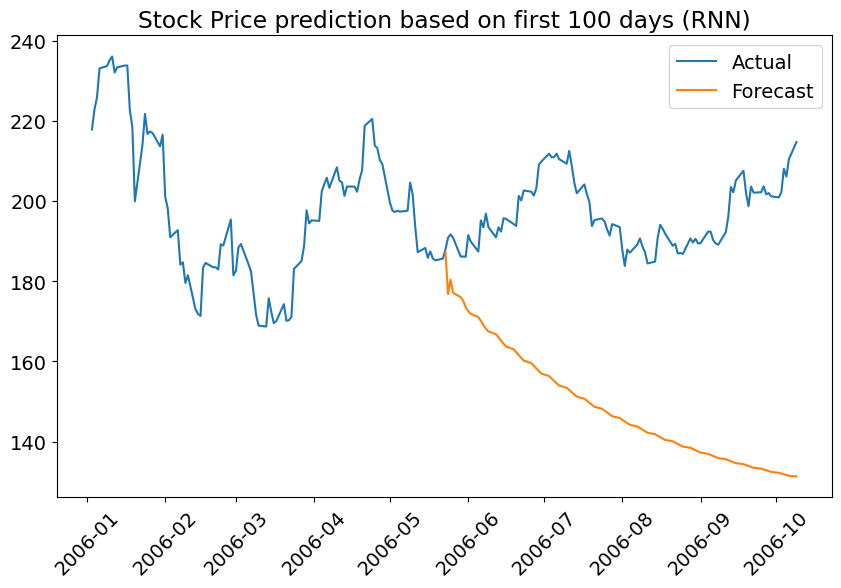

Root Mean Squared Error: 50.5508052359225


In [ ]:
import matplotlib.dates as mdates

plt.figure(figsize=(10, 6))

# Plot actual values
plt.plot(data.index[:200],data_vals[:200, 3], label='Actual')

# Plot predicted values
plt.plot(data.index[100:200],forecasts_rescaled[:, 3], label='Forecast')

# Rotate the x-axis labels for better readability
plt.xticks(rotation=45)

# Add legend and title
plt.legend()
plt.title("Stock Price prediction based on first 100 days (RNN)")
plt.savefig("Stock Price prediction based on first 100 days (RNN).png")
plt.show()

rmse = np.sqrt(mean_squared_error(data_vals[100:200, 3], forecasts_rescaled[:, 3]))
print(f"Root Mean Squared Error: {rmse}")